# Project 1 - Mc907/Mo651 - Mobile Robotics

### Student:
Luiz Eduardo Cartolano - RA: 183012

### Instructor:
Esther Luna Colombini

### Subject of this Work:
The general objective of this work is to build, on the V-REP robotic simulator, an odometry and feature extraction system for the Pioneer P3-DX robot.

### Goals:
1. Implement the kinematic model of the differential robot P3DX and compute the robot odometry through its kinematic model.
2. Acquire sensor data as the robot moves around and display features (point cloud, objects, etc.) extracted from them in global coordinates.



# Code Starts Here

Import of used libraries

In [4]:
from lib import vrep
import sys, time
from src import robot as rb
from src.utils import vrep2array
import math
from time import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Defining the kinematic model of the Pionner P3DX
For this project, we are going to use the configuration of the mobile robot being characterized by the position (x,y) and the orientation in a Cartesian coordinate.

Using the follow parameters:
1. $V_R$: linear velocity of the right wheel.
2. $V_L$: linear velocity of the left wheel.
3. $W$: angular velocity of the mobile robot.
4. $X$: abscissa of the robot.
5. $Y$: intercept of the robot.
6. $X,Y$ : the actual position coordinates.
7. $\theta$: orientation of the robot.
8. $L$: the distance between the driving wheels.

The kinematic model is given by these equations [1](https://www.hindawi.com/journals/cin/2016/9548482/abs/):
<br>
\begin{align}
\frac{dX}{dt} & = \frac{V_L + V_R}{2} \cdot cos(\theta) \\
\frac{dY}{dt} & = \frac{V_L + V_R}{2} \cdot sen(\theta) \\
\frac{d \theta}{dt} & = \frac{V_L - V_R}{2} \\
\end{align}
<br>
Where ($X$,$Y$ and $\theta$) are the robot actual position and orientation angle in world reference frame. In simulation, we use the discrete form to build a model of the robot. The discrete form of the kinematic model is given by the following equations:<br>
<br>
\begin{align}
X_{k+1} & = X_k + T \cdot \frac{V_{lk} + V_{rk}}{2} \cdot cos(\theta_k + \frac{d \theta}{dt} ) \\
Y_{k+1} & = Y_k + T \cdot \frac{V_{lk} + V_{rk}}{2} \cdot sen(\theta_k + \frac{d \theta}{dt}) \\
\theta_{k+1} & = \theta_k + T \cdot \frac{V_{lk} + V_{rk}}{L} \\
\end{align}
<br>

where $X_{k+1}$ and $Y_{k+1}$ represent the position of the center axis of the mobile robot and $T$ is the sampling time.

In [5]:
class Pose:
    """
    A class used to store the robot pose.
    
    ...
    
    Attributes
    ----------
    x : double
        The x position of the robot on the map
    y : double
        The y position of the robot on the map
    orientation : double
        The angle theta of the robot on the map
        
    Methods
    -------
    The class doesn't have any methods
    """
    def __init__(self, x=None, y=None, orientation=None):
        self.x = x
        self.y = y
        self.orientation = orientation

In [6]:
class Odometry():
    """
    A class used to implement methods that allow a robot to calculate his own odometry.

    ...

    Attributes
    ----------
    robot : obj
        The robot object
    lastPose : obj Pose
        Store the robot's pose during his movement
    lastTimestamp : time
        Store the last timestamp
    left_vel : double
        Store the velocity of the left robot wheel
    right_vel : double
        Store the velocity of the right robot wheel
    delta_time : double
        Store how much time has passed
    delta_theta : double
        Store how the orientation change
    delta_space : double
        Store how the (x,y) change

    Methods
    -------
    ground_truth_updater()
        Function to update the ground truth, the real pose of the robot at the simulator
    odometry_pose_updater()
        Function to estimate the pose of the robot based on the kinematic model 
    """
    def __init__(self, robot):
        self.robot = robot
        self.lastPose = None
        self.lastTimestamp = time()
        self.left_vel = 0
        self.right_vel = 0
        self.delta_time = 0
        self.delta_theta = 0
        self.delta_space = 0
        
    def ground_truth_updater(self):
        """
            Function to update the ground truth, the real pose of the robot at the simulator
        """
        # get the (x,y,z) position of the robot at the simulator
        pose = self.robot.get_current_position()
        # get the orientation of the robot (euler angles)
        orientation = self.robot.get_current_orientation()
        
        # return an pose object (x,y,theta)
        return Pose(x=pose[0], y=pose[1], orientation=orientation[2])
    
    def odometry_pose_updater(self):
        """
            Function to estimate the pose of the robot based on the knematic model
        """
        if self.lastPose is None:
            self.lastPose = self.ground_truth_updater()
            return self.lastPose
            
        # get the actual timestamp
        time_now = time()
        # get the robot linear velocity for the left and right wheel
        left_vel, right_vel = self.robot.get_linear_velocity()
        # calculate the difference between the acutal and last timestamp
        delta_time = time_now - self.lastTimestamp
        # calculate the angle deslocation - based on the kinematic model
        delta_theta = (right_vel - left_vel) * (delta_time / self.robot.ROBOT_WIDTH)
        # calculate the distance deslocation - based on the kinematic model
        delta_space = (right_vel + left_vel) * (delta_time / 2)
        
        # auxiliary function to sum angles
        add_deltha = lambda start, delta: (((start+delta)%(2*math.pi))-(2*math.pi)) if (((start+delta)%(2*math.pi))>math.pi) else ((start+delta)%(2*math.pi))

        # calculate the new X pose
        x = self.lastPose.x + (delta_space * math.cos(add_deltha(self.lastPose.orientation, delta_theta/2)))
        # calculate the new Y pose
        y = self.lastPose.y + (delta_space * math.sin(add_deltha(self.lastPose.orientation, delta_theta/2)))
        # calculate the new Orientation pose
        theta = add_deltha(self.lastPose.orientation, delta_theta)
        
        # uptade the state of the class
        self.lastPose = Pose(x, y, theta)
        self.lastTimestamp = time_now
        self.left_vel = left_vel
        self.right_vel = right_vel
        self.delta_time = delta_time
        self.delta_theta = delta_theta
        self.delta_space = delta_space
        
        return self.lastPose

# Defining the class that controls the robot walker

For this project we are going to use simple controllers in order to make the robot move in the map.

### Controllers:
**1. Wall-Follower**
   
   The Wall-Follower is an indoor navigation robot which will automatically approach and follow a wall. In order to implement the behavior, we used the two ultra-sonic in the front of the robot for obstacle avoidance. The other two ultra-sonic on the side are used to detect a wall and tell the robot’s relative position to the wall. So, with that information it's possible, to follow the pipeline:

    1. Firts the robot find a wall:
        Walks until the front sensors are busy
    2. Aling with the wall
        Robot turn in aiming to align his left side with the wall
    3. Follow the wall
        Once aligned with the wall is just keep a safe distance and follow it.

In [7]:
class Walker():
    """
    A class used to implement methods that allow a robot to walk, based on different behaviors.

    ...

    Attributes
    ----------
    robot : obj
        the robot object

    Methods
    -------
    find_wall()
        Function that aims to find a wall in the front of the robot.
    turn_left()
        Function that aims to make the robot turn left.
    follow_wall()
        Function that aims to make the robot follow the wall that stays at his left side.
    """
    def __init__(self, robot):
        """
            Instanciate the object
        """
        self.robot = robot
    
    def find_wall(self):
        """
            Function that aims to find a wall in the front of the robot.
        """
        #  read the sonars
        sensors = self.robot.read_ultrassonic_sensors()
        
        # loop to make the robot walk until he finds a wall
        if sensors[3] > 0.45 and sensors[4] > 0.45:
            # set the initial velocity
            self.robot.set_left_velocity(3)
            self.robot.set_right_velocity(3)
            
            return False
        else:        
            return True
    
    def turn_left(self):
        """
            Function that aims to make the robot turn left.
        """
        # read the sonar sensors
        sensors = self.robot.read_ultrassonic_sensors()

        if (sensors[0] > 0.5 and sensors[15] > 0.5) or (sensors[0] - sensors[15] > 0.1) or (sensors[15] - sensors[0] > 0.1):
            # start the motors velocity
            self.robot.set_left_velocity(1.5)
            self.robot.set_right_velocity(0)
            
            return False
        else:
            return True
        

    def follow_wall(self):
        """
            Function that aims to make the robot follow the wall that stays at his left side.
        """
        sensors = self.robot.read_ultrassonic_sensors()

        if sensors[3] < 0.6 or sensors[4] < 0.6 or sensors[5] < 0.6 or sensors[6] < 0.6:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] < 0.37 or sensors[1] < 0.37 or sensors[2] < 0.37:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] > 0.55 or sensors[1] > 0.55:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(0)
        else:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(1.5)

        return

**2. Fuzzy**
   
   A fuzzy control system is a control system based on fuzzy logic—a mathematical system that analyzes analog input values in terms of logical variables that take on continuous values between 0 and 1, in contrast to classical or digital logic, which operates on discrete values of either 1 or 0 (true or false, respectively).
   
   The input variables in a fuzzy control system are in general mapped by sets of membership functions similar to this, known as "fuzzy sets". The process of converting a crisp input value to a fuzzy value is called "fuzzification". A control system may also have various types of switch, or "ON-OFF", inputs along with its analog inputs, and such switch inputs of course will always have a truth value equal to either 1 or 0, but the scheme can deal with them as simplified fuzzy functions that happen to be either one value or another. Given "mappings" of input variables into membership functions and truth values, the microcontroller then makes decisions for what action to take, based on a set of "rules", each of the form:
~~~
    IF brake temperature IS warm AND speed IS not very fast
    THEN brake pressure IS slightly decreased.
~~~

   For this project hte implemented fuzzy was very simples, and aims just to make the robot abble to avoid obstacles on his way. He uses the ultrassonic sensors for his three inputs (front, left and right distance) and outputs the linear velocity for both weels.
    

In [8]:
class FuzzyControler():
    """
    A class used to implement methods that allow a robot to walk, based on a fuzzy logic controller.

    ...

    Attributes
    ----------
    forward: skfuzzy object
        Skfuzzy input object
    left: skfuzzy object
        Skfuzzy input object    
    right: skfuzzy object
        Skfuzzy input object    
    output_left: skfuzzy object
        Skfuzzy output object
    output_right: skfuzzy object
        Skfuzzy output object    
    rules: skfuzzy object
        List of rules to the fuzzy
    control: skfuzzy object
        Skfuzzy controller object
    simulator: skfuzzy object
        Skfuzzy simulator object

    Methods:
    
    -------
    create_inputs()
        Function to create skfuzzy input functions
    create_outputs()
        Function to create skfuzzy output functions        
    create_rules()
        Function to create skfuzzy rules
    create_control()
        Function to create skfuzzy controller
    show_fuzzy()
        Function to show the fuzzy rules as a graph
    create_simulator()
        Function that controls the fuzzy pipeline
    simulate()
        Function that give outputs velocity based on input distance
    """


    def __init__(self):
        self.forward = None
        self.left = None
        self.right = None
        self.output_left = None
        self.output_right = None
        self.rules = []
        self.control = None
        self.simulator = None
    
    def create_inputs(self):
        # variable universe        
        x_dst = np.arange(0, 1, 0.00001)
        
        # create skfuzzy object
        self.forward = ctrl.Antecedent(x_dst, 'forward')
        self.left = ctrl.Antecedent(x_dst, 'left')
        self.right = ctrl.Antecedent(x_dst, 'right')
        
        # set the variable universe as near, medium and far
        self.forward['near'] = fuzz.trapmf(x_dst, [0.00397, 0.0145, 0.242063492063492, 0.374])
        self.forward['medium'] = fuzz.trapmf(x_dst, [0.295, 0.366, 0.55, 0.652116402116402])
        self.forward['far'] = fuzz.trapmf(x_dst, [0.583333333333333, 0.702, 1.00, 1.0])
        
        self.left['near'] = fuzz.trapmf(x_dst, [0.00132, 0.0119, 0.261, 0.358465608465608])
        self.left['medium'] = fuzz.trapmf(x_dst, [0.287, 0.374, 0.55, 0.675925925925926])
        self.left['far'] = fuzz.trapmf(x_dst, [0.61, 0.705026455026455, 1.03, 1.3])
        
        self.right['near'] = fuzz.trapmf(x_dst, [0.00132, 0.0119, 0.261, 0.358465608465608])
        self.right['medium'] = fuzz.trapmf(x_dst, [0.287, 0.374, 0.55, 0.675925925925926])
        self.right['far'] = fuzz.trapmf(x_dst, [0.61, 0.705026455026455, 1.03, 1.3])
        
        return
    
    def create_outputs(self):
        # variable universe 
        x_out = np.arange(-1,1, 0.00001)
        
        # create skfuzzy object
        self.output_left = ctrl.Consequent(x_out, 'output_left')
        self.output_right = ctrl.Consequent(x_out, 'output_right')
        
        # set the variable universe as reverse, slow, normal and fast
        self.output_left['reverse'] = fuzz.trapmf(out_dst, [-1, -1, 0, 0])
        self.output_left['slow'] = fuzz.trapmf(out_dst, [0.0, 0.0, 0.5, 0.5])
        self.output_left['normal'] = fuzz.trapmf(out_dst, [0.4, 0.4, 0.8, 0.8])
        self.output_left['fast'] = fuzz.trapmf(out_dst, [0.7, 0.7, 1.0, 1.0])
        
        self.output_right['reverse'] = fuzz.trapmf(out_dst, [-1, -1, 0, 0])
        self.output_right['slow'] = fuzz.trapmf(out_dst, [0.0, 0.0, 0.5, 0.5])
        self.output_right['normal'] = fuzz.trapmf(out_dst, [0.4, 0.4, 0.8, 0.8])
        self.output_right['fast'] = fuzz.trapmf(out_dst, [0.7, 0.7, 1.0, 1.0])
        
        return
    
    def create_rules(self, forward, left, right, output_left, output_right):
        # rule 1
        rule1 = ctrl.Rule(antecedent=(forward['near'] & left['near'] & right['far']),
                          consequent=(output_left['fast'], output_right['slow']))
        # rule 2
        rule2 = ctrl.Rule(antecedent=(forward['near'] & left['near'] & right['medium']),
                          consequent=(output_left['normal'], output_right['fast']))
        # rule 3
        rule3 = ctrl.Rule(antecedent=(forward['medium'] & left['medium'] & right['far']),
                          consequent=(output_left['normal'], output_right['slow']))
        # rule 4
        rule4 = ctrl.Rule(antecedent=(forward['medium'] & left['near'] & right['far']),
                          consequent=(output_left['fast'], output_right['slow']))
        # rule 5
        rule5 = ctrl.Rule(antecedent=(forward['medium'] & left['medium'] & right['medium']),
                          consequent=(output_left['slow'], output_right['slow']))
        # rule 6
        rule6 = ctrl.Rule(antecedent=(forward['medium'] & left['near'] & right['medium']),
                          consequent=(output_left['fast'], output_right['slow']))
        # rule 7
        rule7 = ctrl.Rule(antecedent=(forward['far'] & left['far'] & right['far']),
                          consequent=(output_left['fast'], output_right['fast']))
        # rule 8
        rule8 = ctrl.Rule(antecedent=(forward['near'] & left['medium'] & right['far']),
                          consequent=(output_left['slow'], output_right['fast']))
        # rule 9
        rule9 = ctrl.Rule(antecedent=(forward['near'] & left['near']),
                          consequent=(output_left['slow'], output_right['fast']))
        # rule 10
        rule10 = ctrl.Rule(antecedent=(left['near']),
                          consequent=(output_left['fast'], output_right['slow']))
        # rule 11
        rule11 = ctrl.Rule(antecedent=(forward['medium'] & left['medium'] & right['near']),
                          consequent=(output_left['normal'], output_right['reverse']))
        # rule 12
        rule12 = ctrl.Rule(antecedent=(forward['medium'] & left['far'] & right['near']),
                          consequent=(output_left['slow'], output_right['fast']))
        # rule 13
        rule13 = ctrl.Rule(antecedent=(forward['near'] & left['medium'] & right['near']),
                          consequent=(output_left['fast'], output_right['slow']))
        # rule 14
        rule14 = ctrl.Rule(antecedent=(forward['near'] & right['near']),
                          consequent=(output_left['slow'], output_right['normal']))
        # rule 15
        rule15 = ctrl.Rule(antecedent=(right['near']),
                          consequent=(output_left['reverse'], output_right['normal']))
        # rule 16
        rule16 = ctrl.Rule(antecedent=(forward['near']),
                          consequent=(output_left['reverse'], output_right['normal']))
        
        for i in range(1, 17):
            self.rules.append(eval("rule" + str(i)))
            
        return
    
    def create_control(self):
        # call function to create robot input
        self.create_inputs()
        # call function to create robot output
        self.create_outputs()
        # call function to create rules
        self.create_rules(self.forward, self.left, self.right, self.output_left, self.output_right)
        # create controller
        self.control = skfuzzy.control.ControlSystem(self.rules)
        
        return
    
    def show_fuzzy(self):         
        if self.control is None:
            raise Exception("Control not created yet!")
        else:
            self.control.view()
    
        return
    
    def create_simulator(self):
        if self.control is None:
            # crete controller if it doensn't exist
            self.create_control()
        # create simulator object
        self.simulator = ctrl.ControlSystemSimulation(self.control)
        
        return
            
    def simulate(self, input_foward=None, input_left=None, input_right=None):
        if self.simulator is None:
            # crete simulator if it doensn't exist
            self.create_simulator()
        
        # if there is no input raise exception
        if input_foward is None or input_left is None or input_right is None:
            raise Exception("Inputs can't be none")
        
        # simulte the robot linear velocity based on given inputs
        self.simulator.input['forward'] = input_foward
        self.simulator.input['left'] = input_left
        self.simulator.input['right'] = input_right
        
        self.simulator.compute()
        
        return self.simulator.output['output_left'], self.simulator.output['output_right']

# Defining the Feature Extractor of the robot

For this project we tried to implement two different strategies to extract features from the environment. 

### Definition:
Feature extraction and selection are important steps in the construction of a map to support the navigation of mobile robots in outdoor environments. The large amount of data acquired by the on-board sensors has to be reduced to retain only the crucial information for the navigation purpose. This procedure should be robust given the rough, dynamic and unpredictable conditions provided by outdoor scenarios.


### Extractors:
**1. Image Extractor**
   
Feature extraction operates on an image and returns one or more image features. Features are typically scalars (for example area or aspect ratio) or short vectors (for example the coordinate of an object or the parameters of a line). Image feature extraction is a necessary first step in using image data to control a robot. It is an information concentration step that reduces the data.

**Note:** Unfortunately, the feature extractor using image input is not working as expected, so it's not going to be used on this project. While the development we found several problemns on the quality of the hough tranformed output and also on convert the coordinates from the camera to "real world" coordinates. However, we are still going to explain the image processing techniques used and the pipeline of the extractor.

**Techniques:**

1. Hough transform

Is a feature extraction method for detecting simple shapes such as circles, lines etc in an image. A “simple” shape is one that can be represented by only a few parameters. For example, a line. The polar form of a line is represented as: $\rho = x cos(\theta) + y sen(\theta)$. Here $\rho$ represents the perpendicular distance of the line from the origin in pixels, and $\theta$ is the angle measured in radians. The accumulator because we will use the bins of this array to collect evidence about which lines exist in the image.

Steps operated in order to extract lines from image:

    1. Initialize Accumulator
    2. Detect Edges
    3. Voting by Edge Pixels

2. Corner Detection

In order to detect corners, we iterate over the founded lines, and check if exists an intercept point between then. To this, we use the following formula:
\begin{align}
P_x = \frac{(x_1 y_2-y_1 x_2)(x_3-x_4)-(x_1-x_2)(x_3 y_4-y_3 x_4)}{(x_1-x_2)(y_3-y_4)-(y_1-y_2)(x_3-x_4)} \\
P_y = \frac{(x_1 y_2-y_1 x_2)(y_3-y_4)-(y_1-y_2)(x_3 y_4-y_3 x_4)}{(x_1-x_2)(y_3-y_4)-(y_1-y_2)(x_3-x_4)}
\end{align}

In [9]:
class ImageError(Exception):
    """Raised when the input is None"""
    pass

In [10]:
class Frame():
    """
    A class used to store the image the robot saw.
    
    ...
    
    Attributes
    ----------
    pose : object
        The pose of the robot in the moment the "picture was taken"
    image : numpy.array
        The matrix of pixels of the image
    timestamp : time object
        The time when the "picture was taken"
        
    Methods
    -------
    The class doesn't have any methods
    """

    def __init__(self, pose, image, wall_distance, timestamp=None):
        self. pose = pose
        self.image = image
        self.wall_distance = wall_distance
        self.timestamp = time()

In [11]:
class FeatureExtractor():
    """
    A class used to implement the methods that are going to extract features to the robot.
    
    ...
    
    Attributes
    ----------
    robot : object
        The robot object
    firs_image : object
        The frame object
        
    Methods
    -------
    step(self)
        Function that controls the pipeline of the feature extraction.
    update(self)
        Function that updates the robot stored image.
    hough_transform(self, image)
        Function that uses the hough transformed to detect lines on the image.
    corner_detect(self, lines)
        Function that detect corners from a list of lines.
    """
    def __init__(self, robot):
        self.robot = robot
        self.first_image = None
        
        
    def step(self):
        """
            Function that controls the pipeline of the feature extraction.
        """
        if self.update():
            try:
                lines = self.hough_transform(self.first_image.image)
                corner = self.corner_detect(lines)
                line_distance = self.find_distance(lines)
                if line_distance != -1:
                    self.map_coordinates(line_distance, self.first_image.pose)
                return (lines, corner)
            except:
                raise ImageError
        else:
            raise ImageError
        
    def update(self):
        """
            Function that updates the robot stored image.
        """
        # get distance between robot and a wall
        wall_distance = min(self.robot.read_ultrassonic_sensors()[3:5])
        # get the (x,y,z) position of the robot at the simulator
        pose = self.robot.get_current_position()
        # get the orientation of the robot (euler angles)
        orientation = self.robot.get_current_orientation()

        # read camera
        image = self.robot.read_vision_sensor()
        image = vrep2array(image[1],image[0])
        # form pose
        pose = Pose(x=pose[0], y=pose[1], orientation=orientation[2])
        # attribute image
        self.first_image = Frame(pose=pose, image=image, wall_distance=wall_distance)

        return True
        
        
    def hough_transform(self, image):
        """
            Function that uses the hough transformed to detect lines on the image.
            
            :input: image - numpy.array of the image pixels
            :return: points - list with the found lines
        """
        # make the image gray (2 channels)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # apply the hough transformed
        lines = cv2.HoughLines(gray, 1, np.pi/2, 60)
        points = []
        for  line in lines:
            for rho,theta in line:
                # iterate over lines in order to find the (x_start, y_start) and (x_end, y_end) of the lines
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                points.append([(x1, y1), (x2, y2)])

        return points
    
    def corner_detect(self, lines):
        """
            :input: lines - list with the lines found on the image
            :return: corner - list with the (x,y) position of lines intersection
        """
        corner = []
        for line1, line2 in zip(lines, lines[1:]):
            # find the distance of the x points between two lines 
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            # find the distance of the y point between two lines
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
            
            # calc the determinant
            det = lambda  a, b: a[0] * b[1] - a[1] * b[0]
            div = det(xdiff, ydiff)

            if div == 0:
                continue
            else:
                # calc the point of intercept
                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div

            corner.append((x,y))

        return corner
    
    def map_coordinates(self, line_size, robot_pose):
        angle = math.degrees(robot_pose.orientation)
        if angle <= 45 or angle >= -45:
            return
            print("SOMA X: ", line_size)
        elif angle < -45 or angle > -135:
            return
            print("SUBTRAI Y: ", line_size)
        elif angle < -135 or angle > 135:
            return
            print("SUBTRAI X: ", line_size)
        else:
            return
            print("SOMA Y: ", line_size)
            
    def find_distance(self, lines):
        max_dist = -1
        for line in lines:
            if line[2] < 0.3:
                pass
            else:
                dst = (((line[1][0] - line[0][0])**2) + ((line[1][1] - line[0][1])**2)) ** (1/2)
                if dst > max_dist:
                    max_dist = dst
        
        return max_dist

**2. KMeans Clustering Extractor**

K-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. The algorithm has a loose relationship to the k-nearest neighbor classifier, a popular machine learning technique for classification that is often confused with k-means due to the name.

**How It Works:**

Given a set of observations $(x_1, x_2, ..., x_n)$, where each observation is a d-dimensional real vector, k-means clustering aims to partition the n observations into k $(≤ n)$ sets $S = {S_1, S_2, ..., S_k}$ so as to minimize the variance. Formally, the objective is to find:

\begin{align}
\underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^{k} \sum_{\mathbf x \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2 = \underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^k |S_i| \operatorname{Var} S_i \end{align}

**How we use KMeans for mapping:**

To apply the KMeans for mapping we extract enviroment information from the LIDAR (laser sensors) when the robot were close to some object (we check the robot distance from other objects using the ultrassonic sensor). So, once the LIDAR gives us the (x,y,z) information about the perceived objetc on the scene, it was necessary to perform few steps in order to acquire data:

    1. First we clean the data, extracting just the (x,y) position
    2. We apply the KMeans fit function (specifying the number of clusters)
    3. We extract the centroids of the clusters as the position of objects on the scene
    
**Why we choose to use KMeans:**

K-means is one of the simplest algorithm which uses unsupervised learning method to solve known clustering issues. It works really well with large datasets and it's not very computational expensive. And this algorithm is guaranteed to converge to a result.

Furthermore, the major drawbacks K-means usually show aren't big problem for us here, since we don't need high quality clusters, or totally free noise information, this is, we can pay this drawbacks in order to have a fast algorithm that is also very easy to implement. And, obviously, we can't forget the main fact, that it reduces the LIDAR data from around 500 position to the set number of clusters we ask.

In [45]:
class KMeansClustering():
    """
    A class used to implement KMeans to extract information from the enviroment.
    
    ...
    
    Attributes
    ----------
    robot : object
        The robot object
        
    Methods
    -------
    step()
        Function that controls the pipeline of the feature extraction.
    kmean_fit()
        Function that fits the model
    centroids_points()
        Function that return cluster centroids
    """
    def __init__(self, robot):
        self.robot = robot
    
    def step(self):
        """
            Function that controls the pipeline of the feature extraction.
            
            :return: centroid_pos - position of clusters centroids
        """
        if  min(self.robot.read_ultrassonic_sensors()[0:15]) < 1.0:
            raw_lidar = self.robot.read_laser()
            points = []
            for i in range(0,len(raw_lidar),3):
                points.append([raw_lidar[i], raw_lidar[i+1]])
            
            clusters = self.kmean_fit(points)
            centroids_pos = self.centroids_points(clusters)
            
            return centroids_pos
        else:
            return np.array([])
        
    def kmean_fit(self, points):
        """
            Function that fits the model
            :input: points - lidar data
            :return: y_ - the kmeans object from sklearn
        """
        kmeans = KMeans()
        y_ = kmeans.fit(points)
        
        return y_
    
    def centroids_points(self, kmeans_obj):
        """
            Function that return cluster centroids
            :input: kmeans_obj - the kmeans object from sklearn
            :return: position of clusters centroids
        """
        return kmeans_obj.cluster_centers_
    

# Controls robot actions

Simple state machine that organize the robot behavior and store the informations that will be plot.

In [13]:
def state_machine(behavior="follow_wall"):
    # first we create the robot and the walker object
    robot = rb.Robot()
    walker_behavior = Walker(robot)
    
    # create the FeatureExtractor robot
    #feature_extractor = FeatureExtractor(robot)
    kmeans_extractor = KMeansClustering(robot)
    
    # instantiate the odometry calculator
    odometry_calculator = Odometry(robot=robot)
    
    if behavior == "follow_wall":

        # first we find a wall
        while not walker_behavior.find_wall():
            # read image
            try:
                #lin, cor = feature_extractor.step()
                #lines.append(lin)
                #corners.append(cor)
                points = kmeans_extractor.step()
                if points.size != 0:
                    points_kmeans.append(points)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))
            
        robot.stop()
        # calculate the estimate new position after find a wall
        temp_ground = odometry_calculator.ground_truth_updater()
        ground_truth.append((temp_ground.x, temp_ground.y))
        temp_odom = odometry_calculator.odometry_pose_updater()
        odometry.append((temp_odom.x, temp_odom.y))

    
        # then we align to the wall
        while not walker_behavior.turn_left():
            # read image
            try:
                #lin, cor = feature_extractor.step()
                #lines.append(lin)
                #corners.append(cor)
                points = kmeans_extractor.step()
                if points.size != 0:
                    points_kmeans.append(points)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))        
        
        robot.stop()
        # calculate the estimate new position after find a wall
        temp_ground = odometry_calculator.ground_truth_updater()
        ground_truth.append((temp_ground.x, temp_ground.y))
        temp_odom = odometry_calculator.odometry_pose_updater()
        odometry.append((temp_odom.x, temp_odom.y))


        # now we follow the wall
        while True:
            # read image
            try:
                #lin, cor = feature_extractor.step()
                #lines.append(lin)
                #corners.append(cor)
                points = kmeans_extractor.step()
                if points.size != 0:
                    points_kmeans.append(points)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))        

            # call the function that keeps following the left wall
            walker_behavior.follow_wall()
    else:
        raise Exception("Not implemented!")
        

# Main function - Execute the code here!
Here is a simple signal handler implement in order to make the simulator execution last for a given time period.

In [51]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

try:
    ground_truth = []
    odometry = []
    lines = []
    corners = []
    points_kmeans = []
    with time_limit(90):
        state_machine()
except TimeoutException as e:
    print("Timed out!")

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.
Timed out!


# Some Results
In order to show how the implemented code works we are going to do and discuss three experiments.

## First Experiment

In the first experiment the robot were placed as shown in the following image: <br>
![Test](images/experiment1.png)

**The obtained results following, and discussions about them are bellow the grafics.**

In [28]:
# we take the negative in order to simulate the VREP orientation
odometry_x_1 = [-i[0] for i in odometry]
odometry_y_1 = [-i[1] for i in odometry]
ground_truth_x_1 = [-i[0] for i in ground_truth]
ground_truth_y_1 = [-i[1] for i in ground_truth]

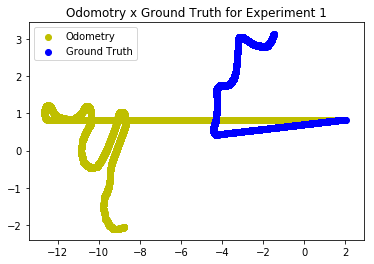

In [29]:
plt.figure()
plt.title('Odomotry x Ground Truth for Experiment 1')
plt.scatter(odometry_x_1, odometry_y_1, c='y',label='Odometry')
plt.scatter(ground_truth_x_1, ground_truth_y_1, c='b',label='Ground Truth')
plt.legend()
plt.show()

In [30]:
final_mapping_x_1 = []
final_mapping_y_1 = []
for array_ in points_kmeans:
    for point in array_:
        final_mapping_x_1.append(-point[0])
        final_mapping_y_1.append(-point[1])       

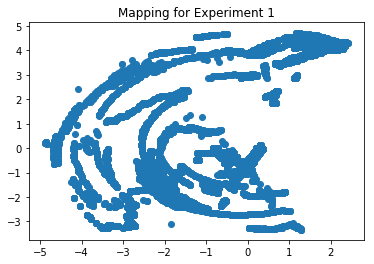

In [31]:
plt.figure()
plt.title('Mapping for Experiment 1')
plt.scatter(final_mapping_x_1, final_mapping_y_1)
plt.show()

## Second Experiment

In the second experiment the robot were placed as shown in the following image: <br>
![Test](images/experiment2.png)

**The obtained results following, and discussions about them are bellow the grafics.**

In [33]:
# we take the negative in order to simulate the VREP orientation
odometry_x_2 = [-i[0] for i in odometry]
odometry_y_2 = [-i[1] for i in odometry]
ground_truth_x_2 = [-i[0] for i in ground_truth]
ground_truth_y_2 = [-i[1] for i in ground_truth]

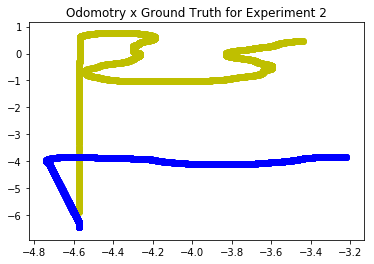

In [34]:
plt.figure()
plt.title('Odomotry x Ground Truth for Experiment 2')
plt.scatter(odometry_x_2, odometry_y_2, c='y')
plt.scatter(ground_truth_x_2, ground_truth_y_2, c='b')
plt.show()

In [35]:
final_mapping_x_2 = []
final_mapping_y_2 = []
for array_ in points_kmeans:
    for point in array_:
        final_mapping_x_2.append(-point[0])
        final_mapping_y_2.append(-point[1])       

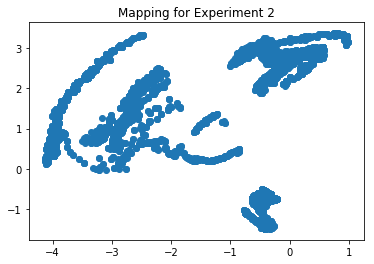

In [36]:
plt.figure()
plt.title('Mapping for Experiment 2')
plt.scatter(final_mapping_x_2, final_mapping_y_2)
plt.show()

## Third Experiment

In the first experiment the robot were placed as shown in the following image: <br>
![Test](./images/experiment3.png)

**The obtained results following, and discussions about them are bellow the grafics.**

In [52]:
# we take the negative in order to simulate the VREP orientation
odometry_x_3 = [-i[0] for i in odometry]
odometry_y_3 = [-i[1] for i in odometry]
ground_truth_x_3 = [-i[0] for i in ground_truth]
ground_truth_y_3 = [-i[1] for i in ground_truth]

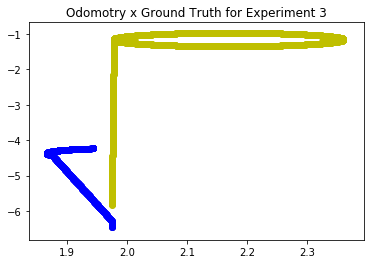

In [53]:
plt.figure()
plt.title('Odomotry x Ground Truth for Experiment 3')
plt.scatter(odometry_x_3, odometry_y_3, c='y')
plt.scatter(ground_truth_x_3, ground_truth_y_3, c='b')
plt.show()

In [54]:
final_mapping_x_3 = []
final_mapping_y_3 = []
for array_ in points_kmeans:
    for point in array_:
        final_mapping_x_3.append(-point[0])
        final_mapping_y_3.append(-point[1])       

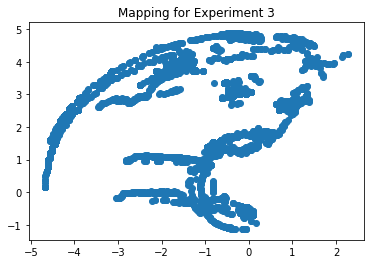

In [55]:
plt.figure()
plt.title('Mapping for Experiment 3')
plt.scatter(final_mapping_x_3, final_mapping_y_3)
plt.show()

# Odometry and Mapping Plot

In [80]:
odometry_x, odometry_y, ground_truth_x, ground_truth_y = [], [], [], []

In [85]:
odometry_x = [-i[0] for i in odometry]
odometry_y = [-i[1] for i in odometry]
ground_truth_x = [-i[0] for i in ground_truth]
ground_truth_y = [-i[1] for i in ground_truth]

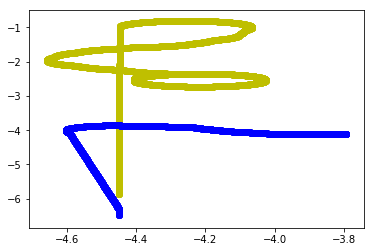

In [86]:
plt.figure()
plt.scatter(odometry_x, odometry_y, c='y')
plt.scatter(ground_truth_x, ground_truth_y, c='b')
plt.show()

In [41]:
final_mapping_x = []
final_mapping_y = []
for array_ in points_kmeans:
    for point in array_:
        final_mapping_x.append(-point[0])
        final_mapping_y.append(-point[1])        

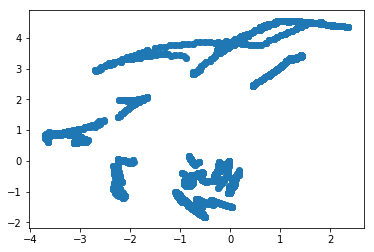

In [42]:
plt.figure()
plt.scatter(final_mapping_x, final_mapping_y)
plt.show()